Задание:
1. Для любых пар изображений которые имеют общее поле зрения (две фотографии сделанные с телефона который был повернут на определенный угол - любой лишь бы было 20+% перекрытия)
Рассчитать матрицу афинного преобразования из одной системы координат в другую. Выполнить разложение данной матрицы и посчитать явно угол поворота, вектор переноса и скалирования. 
Выполнить обратное преобразование - получить афинную матрицу заново. 

https://www.youtube.com/@Vaska_pilot/videos

2) Взять любую видеопоследовательность (желательно вид сверху) - например полет дрона. Можете скачать из  интернета или взять что то с работы. 
Зафиксировав точку (например центр экрана) выполнить стабилизацию данной точки с использованием матрицы афинного преобразования 
(считая матрицу между кадрами вы всегда сможете понять где именно находится точка на изображении, а по отклонению самой точки вы можете определить точность самого алгоритма).
Не берите 4к - долго считать, HD будет достаточно
Посчитать расстояние между точками и ошибку в пикселях.
Попробуйте добавить шум к изображению, посмотрите как меняется точность (положение точки). 
Добавьте фильтр к изображению для улучшения контрастности (любой который найдете).
Оцените как влияет выбор метода определения матрицы афинного преобразования - например estimateAffine2D и его аналоги (аналоги найдите самии).
Оцените как влияет выбор детектора/дескриптора особых точек на результат. Какой метод даст лучший и самый быстрый результат? 

3) LoFTR  - любой другой, сравнить с готовыми решениями. 

Напишите Вывод. 


In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib as plt

In [2]:
import skimage as ski
from skimage.transform import estimate_transform

In [3]:
import cv2
import numpy as np
# Функция для добавления шума к изображению
def add_noise(image, noise_type="gaussian", amount=0.05, mean=0, var=0.01):
    """
    Добавляет шум к цветному изображению.

    Аргументы:
        image (numpy.ndarray): Исходное цветное изображение (BGR).
        noise_type (str): Тип шума ("gaussian", "salt_pepper").
        amount (float): Интенсивность шума (только для "salt_pepper").
        mean (float): Среднее значение (только для "gaussian").
        var (float): Дисперсия шума (только для "gaussian").

    Возвращает:
        noisy_image (numpy.ndarray): Изображение с добавленным шумом.
    """
    if noise_type == "gaussian":
        # Генерация гауссовского шума
        row, col, ch = image.shape
        sigma = var ** 0.5
        gauss = np.random.normal(mean, sigma, (row, col, ch))
        gauss = gauss.reshape(row, col, ch)
        noisy_image = image + gauss * 255
        noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    elif noise_type == "salt_pepper":
        # Генерация шума соли и перца
        noisy_image = np.copy(image)
        total_pixels = image.size
        num_salt = int(amount * total_pixels / 2)
        num_pepper = int(amount * total_pixels / 2)

        # Добавляем соль
        coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape[:2]]
        noisy_image[coords[0], coords[1]] = [255, 255, 255]

        # Добавляем перец
        coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape[:2]]
        noisy_image[coords[0], coords[1]] = [0, 0, 0]

    else:
        raise ValueError("Неподдерживаемый тип шума. Используйте 'gaussian' или 'salt_pepper'.")

    return noisy_image


In [4]:
# Функция для повышения контраста изображения
def contrast_up(image, clipLimit=2.0, tileGridSize=(8, 8)):
    
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Разделение каналов LAB
    l, a, b = cv2.split(lab_image)

    # Создаем CLAHE-объект
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    # Применяем CLAHE к каналу L (яркость)
    l = clahe.apply(l)

    # Объединяем каналы обратно
    lab_image = cv2.merge((l, a, b))

    # Преобразование обратно в BGR
    contrast_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2BGR)
    
    return contrast_image

In [5]:
# Функция для получения особых точек
def extract_features(image, detector='sift', mask=None):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()
    elif detector == 'surf':
        det = cv2.xfeatures2d.SURF_create()
        
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

In [6]:
# Функция для сопоставления особых точек
def match_features(des1, des2, matching='BF', detector='orb', sort=True, k=2):
    if des1 is None or des2 is None:
        return []  # Возвращаем пустой список, если нет дескрипторов

    if matching == 'BF':
        if detector == 'sift' or detector == 'surf':
            matcher = cv2.BFMatcher(cv2.NORM_L2)
        elif detector == 'orb':
            matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
    elif matching == 'FLANN':
        if detector == 'sift' or detector == 'surf':
            index_params = dict(algorithm=1, trees=5)
        elif detector == 'orb':
            index_params = dict(algorithm=6, table_number=6, key_size=12, multi_probe_level=1)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)

    matches = matcher.knnMatch(des1, des2, k=k)
    if sort:
        matches = sorted(matches, key=lambda x: x[0].distance if len(x) > 1 else float('inf'))

    return matches

In [7]:
# Функция для фильтрации особых точек
def filter_matches_distance(matches, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

In [8]:
def visualize_matches(frame1, kp1, frame2, kp2, matches):
    if not kp1 or not kp2 or not matches:
        print("No keypoints or matches to display.")
        return frame1  # Возвращаем исходное изображение, если нет данных

    return cv2.drawMatches(frame2, kp2, frame1, kp1, matches, None,
                           flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


In [9]:
# Функция для получения матрицы аффинного преобразования на базе бибилиотеки scikit
def estimate_partial_transform_scikit(cur_matched_kp, prev_matched_kp):

    tform = estimate_transform('affine', prev_matched_kp, cur_matched_kp)
    return tform
    

In [10]:
# Функция для получения матрицы аффинного преобразования
def estimate_partial_transform(cur_matched_kp, prev_matched_kp ,method):
    """
    
    :param matched_keypoints: output of match_keypoints util function; tuple of (cur_matched_kp, prev_matched_kp)
    :return: transform as list of [dx, dy, da]
    """
    transform = cv2.estimateAffine2D(np.array(prev_matched_kp),
                                           np.array(cur_matched_kp),method=method)[0] #Тут как бы можно играться с тем как будут фильтроватся точки 
                                                                                          #cv2.LMEDS один из параметров который напрямую влияет  
    #print(transform)    
    if transform is not None:
        # translation x
        dx = transform[0, 2]
        # translation y
        dy = transform[1, 2]
        # rotation
        da = np.arctan2(transform[1, 0], transform[0, 0])
    else:
        dx = dy = da = 0

    return [dx, dy, da], transform

In [11]:
# Функция для разложения матрицы аффинного преобразования на компоненты
def decompose_affine_matrix(affine):
    if affine.shape != (3, 3) or affine.dtype != np.float64:
        raise ValueError("Invalid input matrix. Must be a 3x3 double matrix.")

    R = affine[:2, :2]
    U, W, Vt = np.linalg.svd(R)

    rotation = np.dot(U, Vt)
    scaling = np.diag(W)
    translation = affine[:2, 2:]

    return rotation, translation, scaling

# Функция для получения матрицы аффинного преобразования из компонентов
def recompose_affine_matrix(rotation, translation, scaling):
    rotation_scaling = np.dot(rotation, scaling)
    affine = np.eye(3)
    affine[:2, :2] = rotation_scaling
    affine[:2, 2] = translation.flatten()
    return affine



In [12]:
import matplotlib.pyplot as plt 
def visualize_matches_1(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)
    # Убираем оси
    plt.axis('off')

    # Сохраняем график в файл
    plt.savefig('plot_without_axes.png', bbox_inches='tight', pad_inches=0)

Задание 1. Получение матрицы афинного преобразования

In [13]:
# Считываем изображения и приводим их к цветовой гамме RGB
img0 = cv2.imread("./6.jpg")
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
img1 = cv2.imread("./5.jpg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

In [14]:
# Получаем ключевые точки
kp0, des0 = extract_features(img0, 'sift')
kp1, des1 = extract_features(img1, 'sift')

In [15]:
# Сопоставляем и сортируем ключевые точки
kp0, des0 = extract_features(img0, 'sift')
kp1, des1 = extract_features(img1, 'sift')
matches = match_features(des0, des1, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.5)
print('Number of matches after filtering:', len(matches))
visualize_matches_1(img0, kp0, img1, kp1, matches)

In [ ]:
# Получаем матрицу афинного преобразования
src_pts = np.float32([kp0[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp1[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
m , M = estimate_partial_transform(src_pts,dst_pts, cv2.LMEDS)
afine_transform_matrix =  np.append(M,np.array([0,0,1])).reshape(3,3)

In [ ]:
afine_transform_matrix

array([[ 9.60460341e-01, -2.16084805e-01,  7.56082958e+02],
       [ 2.18996641e-01,  9.72572461e-01, -2.20540062e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [ ]:
# Применяем матрицу к второму (повернутому) изображению
im_out = cv2.warpAffine(img1, (afine_transform_matrix)[:2], (img1.shape[1],img1.shape[0]))

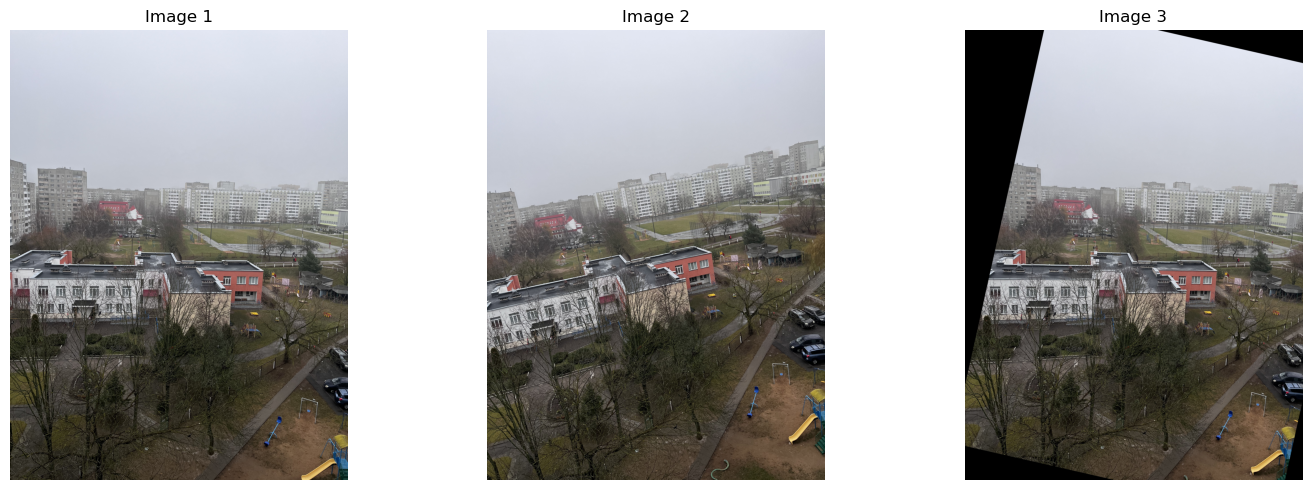

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Создаем фигуру и оси
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 строка, 3 столбца

# Отображаем изображения
axes[0].imshow(img0)
axes[0].set_title('Image 1')
axes[0].axis('off')  # Убираем оси

axes[1].imshow(img1)
axes[1].set_title('Image 2')
axes[1].axis('off')

axes[2].imshow(im_out)
axes[2].set_title('Image 3')
axes[2].axis('off')

# Показываем фигуру
plt.tight_layout()
plt.show()

In [ ]:
# Раскладываем матрицу на составляющие
rotation, translation, scaling  = decompose_affine_matrix(afine_transform_matrix)

In [ ]:
print("Угол:", get_angle_degrees(rotation))
print("Коэффициент скалирования:", get_scale(scaling))
print("Перевод:", get_translation(translation))

Угол: 12.684588883644963
Коэффициент скалирования: 1.4010829492710184
Перевод: [[ 756.08295797]
 [-220.54006185]]


In [ ]:
# Восстанавливаем матрицу
recompose_affine = recompose_affine_matrix(rotation, translation, scaling)

In [ ]:
afine_transform_matrix

array([[ 9.60460341e-01, -2.16084805e-01,  7.56082958e+02],
       [ 2.18996641e-01,  9.72572461e-01, -2.20540062e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [ ]:
recompose_affine

array([[ 9.72592992e-01, -2.16173022e-01,  7.56082958e+02],
       [ 2.18908425e-01,  9.60439810e-01, -2.20540062e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [ ]:
# Применяем восстановленную матрицу к первому изображению и получаем второе
afine_transform_matrix_inverse = np.linalg.inv(recompose_affine)[:2]

im_out = cv2.warpAffine(img0, (afine_transform_matrix_inverse), (img1.shape[1],img1.shape[0]))

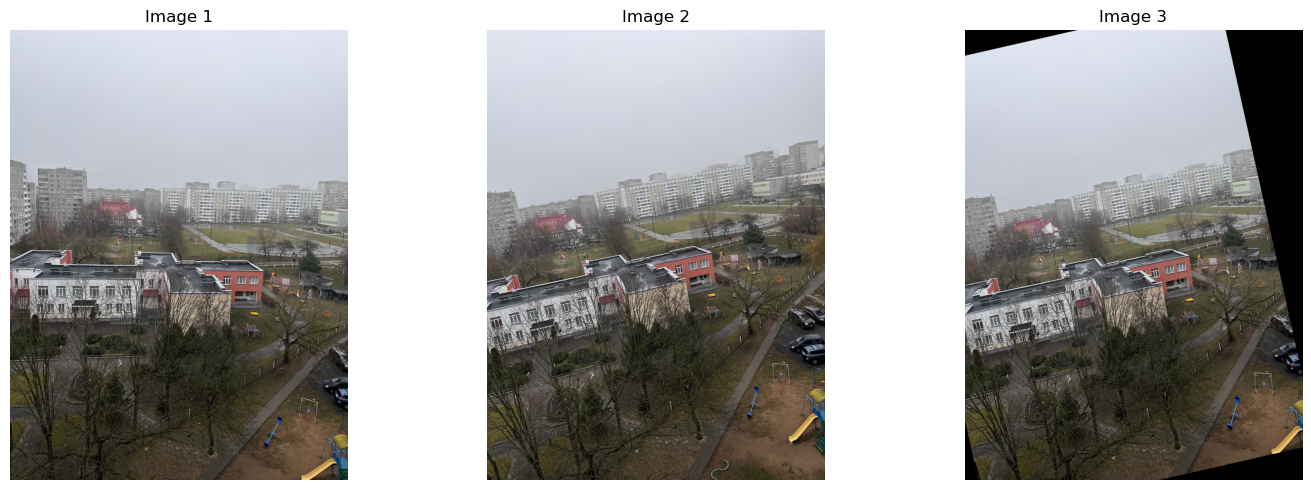

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Создаем фигуру и оси
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 строка, 3 столбца

# Отображаем изображения
axes[0].imshow(img0)
axes[0].set_title('Image 1')
axes[0].axis('off')  # Убираем оси

axes[1].imshow(img1)
axes[1].set_title('Image 2')
axes[1].axis('off')

axes[2].imshow(im_out)
axes[2].set_title('Image 3')
axes[2].axis('off')

# Показываем фигуру
plt.tight_layout()
plt.show()

В результате выполнения первой части задания получена матрица афинного преобразования второго изображения в первое, найдены угол поворота, коэффициент скалирования, трансляция изображения.
Из данных параметров снова получена матрица и выполнено обратное преобразование.

In [15]:
def get_angle(rotation):
    return np.arctan2(rotation[1, 0], rotation[0, 0])

def get_scale(scaling):
    return np.sqrt(scaling[0, 0] ** 2 + scaling[1, 1] ** 2)

def get_translation(translation):
    return translation

def get_angle_degrees(rotation):
    return np.degrees(np.arctan2(rotation[1, 0], rotation[0, 0]))

In [23]:
import math

def calculate_error(start_point_x,start_point_y, end_point_x,end_point_y):
    """
    Расчет длины вектора ошибки
    """
    error = math.sqrt(((end_point_x-start_point_x)**2)+((end_point_y-start_point_y)**2))
    return error

In [17]:
def show_result(img0,img1,error):
    # Создаем фигуру и оси
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1 строка, 3 столбца
    cv2.putText(img1, str(error), (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    # Отображаем изображения
    axes[0].imshow(img0)
    axes[0].set_title('Image 1')
    axes[0].axis('off')  # Убираем оси

    axes[1].imshow(img1)
    axes[1].set_title('Image 2')
    axes[1].axis('off')

In [ ]:
## Saving frames

cap = cv2.VideoCapture('video1.mp4')


if (cap.isOpened()== False): 
    print("Ошибка открытия видеопотока")


frame_num = 0

while(cap.isOpened()):
  
    ret, frame = cap.read()
    frame_num +=1
    

    if ret == True:
        
        if frame_num ==1:
            cv2.imwrite('frame1.jpg', frame)
        
        if frame_num ==200:
            cv2.imwrite('frame200.jpg', frame)
        
    

        cv2.imshow('window',frame)
        


    if cv2.waitKey(25) & 0xFF == ord('q'):
      break

  # Освобождаем ресурсы
cap.release()
out.release()

cv2.destroyAllWindows()

Задание 2.
Ход работы:
 1. Считать 2 кадра видео
 2. Найти особые точки (с помощью разных методов)
 3. Сопоставить контрольные точки
 4. Рассчитать матрицу преобразования
 5. Применить преобразование к исходной точке (заданной для стабилизации)
 6. Оценить ошибку, полученную по окончанию видео.

[[ 1.00034777e+00 -1.12974226e-03 -2.46684543e-01]
 [-5.41118009e-05  1.00036311e+00 -2.15399097e-02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[[238 226 212]
  [238 226 212]
  [238 226 212]
  ...
  [241 220 192]
  [241 220 192]
  [241 220 192]]

 [[238 226 212]
  [238 226 212]
  [238 226 212]
  ...
  [241 220 192]
  [241 220 192]
  [241 220 192]]

 [[238 226 212]
  [238 226 212]
  [238 226 212]
  ...
  [241 220 192]
  [241 220 192]
  [241 220 192]]

 ...

 [[ 66  66  50]
  [ 69  69  53]
  [ 71  71  55]
  ...
  [169 141  61]
  [169 141  61]
  [169 141  61]]

 [[ 68  65  50]
  [ 71  68  53]
  [ 71  71  55]
  ...
  [154 127  50]
  [155 128  51]
  [155 128  51]]

 [[ 71  68  53]
  [ 73  70  55]
  [ 75  75  59]
  ...
  [143 116  39]
  [144 117  40]
  [144 117  40]]]
[[ 1.00045428e+00 -1.54533168e-03 -3.91706718e-01]
 [-1.28651302e-04  1.00121009e+00 -1.13701974e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.00017443e+00 -5.04557633e-04 -1.13785191e-01]
 [-4.044574

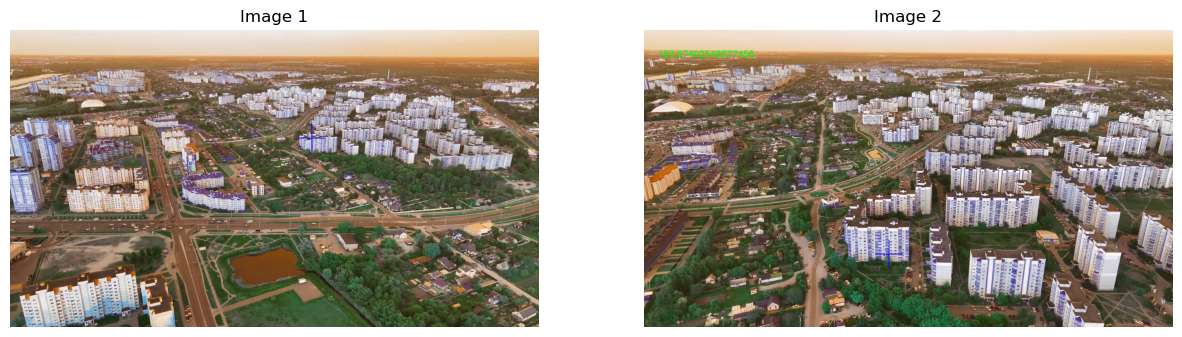

In [22]:
# Читаем видео


cap = cv2.VideoCapture('video1.mp4')

output_filename = 'treker.mp4'
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_filename, fourcc, fps, (frame_width, frame_height))

if (cap.isOpened()== False): 
    print("Ошибка открытия видеопотока")

previous_frame = None
features_frame_prev = None
kp_frame_prev = None
now_frame = None
frame_num = 0
# Исходные координаты точки
x = x_new = 1096
y = y_new = 395


# Итоговые координаты точки
x_res = 737
y_res = 715
scale = 0.5 # Коэффициент уменьшения изображения
error = 0
while(cap.isOpened()):
  
    ret, frame = cap.read()
    frame_num +=1
    

    if ret == True:
      
      
      processing_frame = cv2.resize(frame, (0, 0), fx=scale, fy=scale) # Уменьшаем размер кадра для повышения скорости обработки
      
      kp_frame, features_frame  = extract_features(processing_frame, 'sift')

      if previous_frame is not None:
        
        matches = match_features(features_frame_prev, features_frame, matching='BF', detector='sift', sort=True)
        if matches == []:
          print ("no match")
        
        filtered_match = filter_matches_distance(matches, 0.1)
        
        
        
        src_pts = np.float32([kp_frame_prev[m.queryIdx].pt for m in filtered_match]).reshape(-1, 2)
        dst_pts = np.float32([kp_frame[m.trainIdx].pt for m in filtered_match]).reshape(-1, 2)
        
        
        M = estimate_partial_transform_scikit(src_pts,dst_pts)
        
        afine_transform_matrix = np.linalg.inv(M)
        
        print(afine_transform_matrix)
     
        x_hom = np.array([x*scale,y*scale, 1]) # Вычисляем координату точки на уменьшенном изображении

        x_hom_new = np.dot(afine_transform_matrix, x_hom)
        x_new = x_hom_new[0]/scale # Возвращаемся к координатам на исходном кадре
        y_new = x_hom_new[1]/scale
        #original_image = cv2.circle(frame, (int(x_new),int(y_new)), 5, (255, 0, 0), -1)
        
        center_x, center_y = x_new, y_new  # Центр креста
        line_length = 50               # Длина линии креста
        # Вычисляем координаты концов линий
        start_horizontal = (int(center_x - line_length), int(center_y))
        end_horizontal = (int(center_x + line_length), int(center_y))
        start_vertical = (int(center_x), int(center_y - line_length))
        end_vertical = (int(center_x), int(center_y + line_length))
        # Рисуем горизонтальную линию
        original_image = cv2.line(frame, start_horizontal, end_horizontal, (0, 0, 255), 2)  # Красный цвет (BGR), толщина 2 пикселя

        # Рисуем вертикальную линию
        original_image = cv2.line(frame, start_vertical, end_vertical, (0, 0, 255), 2)
        
        

        cv2.imshow('window',original_image)
        out.write(original_image)
        
        
        if frame_num == 2: # Сохраняем первый кадр
          first_frame = original_image
          print (first_frame)
        
        if frame_num == frame_count: # Сохраняем последний кадр и считаем ошибку
          error = calculate_error(x_res,y_res, x_new,y_new)
          show_result(first_frame, original_image, error)
          print ("Error: ", error)
          break

      previous_frame = frame
      features_frame_prev, kp_frame_prev = features_frame, kp_frame
      x = x_new
      y = y_new

    if cv2.waitKey(25) & 0xFF == ord('q'):
      break

  # Освобождаем ресурсы
cap.release()
out.release()

cv2.destroyAllWindows()

Оптический поток

In [243]:
def get_transform_matrix(img0,img1,method =cv2.LMEDS):
    #Функция которая принимает на вход 2 изображения и возвращает матрицу трансформации и углы поворота по осям. Углы мы не используем. 
    gray0 = cv2.cvtColor(img0,cv2.COLOR_BGR2GRAY)
    gray1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)

    corners0 = cv2.goodFeaturesToTrack(gray0,200, 0.005, 10)

    
    corners1, status, err = cv2.calcOpticalFlowPyrLK(gray0,
                                            gray1,
                                            corners0, None)
    # Отбираем хорошие точки
    good_new = corners1[status == 1]
    good_old = corners0[status == 1]
    # Преобразуем точки в объекты KeyPoint
    kp1 = [cv2.KeyPoint(x=float(p[0]), y=float(p[1]), size=1) for p in good_old]
    kp2 = [cv2.KeyPoint(x=float(p[0]), y=float(p[1]), size=1) for p in good_new]
    
    # Создаем объекты DMatch
    matches = [cv2.DMatch(_imgIdx=0, _queryIdx=i, _trainIdx=i, _distance=0) for i in range(len(kp1))]
    
    # Визуализируем совпадения
    match_img = cv2.drawMatches(img0, kp1, img1, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

    return match_img ,kp1 ,kp2

In [94]:
match_img ,kp1 ,kp2  = get_transform_matrix(img0,img1,method =cv2.LMEDS)

In [ ]:

cap = cv2.VideoCapture('video1.mp4')

output_filename = 'treker.mp4'
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_filename, fourcc, fps, (frame_width, frame_height))

if (cap.isOpened()== False): 
    print("Ошибка открытия видеопотока")

previous_frame = None
features_frame_prev = None
kp_frame_prev = None
now_frame = None
frame_num = 0
x = x_new = 1096
y = y_new = 395

#x = x_new = 1554
#y = y_new = 255

x_res = 737
y_res = 715

#x_res = 1013
#y_res = 326
first_frame = None

error = 0
while(cap.isOpened()):
  
    ret, frame = cap.read()
    frame_num +=1
    

    if ret == True:
      
      if previous_frame is not None:
        
        match_img ,kp1 ,kp2  = get_transform_matrix(previous_frame,frame,method =cv2.LMEDS)
        
        src_pts = np.float32([m.pt for m in kp1]).reshape(-1, 1, 2)
        dst_pts = np.float32([m.pt for m in kp2]).reshape(-1, 1, 2)
        print (len(src_pts))
        print (len(dst_pts))
 

        m , M = estimate_partial_transform(src_pts,dst_pts, cv2.LMEDS)
        

        afine_transform_matrix =  np.append(M,np.array([0,0,1])).reshape(3,3)

        
      
        afine_transform_matrix = np.linalg.inv(afine_transform_matrix)[:2]

        afine_transform_matrix =  np.append(afine_transform_matrix,np.array([0,0,1])).reshape(3,3)
      

        x_hom = np.array([x,y, 1])

        x_hom_new = np.dot(afine_transform_matrix, x_hom)
        x_new = x_hom_new[0]
        y_new = x_hom_new[1]
        
        #original_image = cv2.circle(frame, (int(x_new),int(y_new)), 5, (255, 0, 0), -1)
        
        
        center_x, center_y = x_new, y_new  # Центр креста
        line_length = 50               # Длина линии креста
        # Вычисляем координаты концов линий
        start_horizontal = (int(center_x - line_length), int(center_y))
        end_horizontal = (int(center_x + line_length), int(center_y))
        start_vertical = (int(center_x), int(center_y - line_length))
        end_vertical = (int(center_x), int(center_y + line_length))
        # Рисуем горизонтальную линию
        original_image = cv2.line(frame, start_horizontal, end_horizontal, (0, 0, 255), 2)  # Красный цвет (BGR), толщина 2 пикселя

        # Рисуем вертикальную линию
        original_image = cv2.line(frame, start_vertical, end_vertical, (0, 0, 255), 2)

        

        cv2.imshow('window',original_image)
        out.write(original_image)
        
        if frame_num == 2:
          first_frame = original_image
          print (first_frame)
        
        if frame_num == frame_count:
          error = calculate_error(x_res,y_res, x_new,y_new)
          show_result(first_frame, original_image, error)
          print ("Error: ", error)
          break
          
      previous_frame = frame
      previous_frame_proc = processing_frame
      features_frame_prev, kp_frame_prev = features_frame, kp_frame
      x = x_new
      y = y_new

    if cv2.waitKey(25) & 0xFF == ord('q'):
      break

  # Освобождаем ресурсы
cap.release()
out.release()

cv2.destroyAllWindows()

Выводы:
При оценке результатов использовалась длина вектора ошибки.
1. Наилучший результат (ошибка 68) получен при использовании метода оптического потока. Также оптический поток является наиболее быстрым методом.
    - при добавлении шума ошибка увеличилась до 79 (на ~ 14%)
    - при увеличении контраста ошибка также увеличилась (до 99) (на ~30%).

2. При использовании SIFT ошибка составила 212.
    - при добавлении шума ошибка уменьшилась до 190 (на ~ 10%)
    - при увеличении контраста ошибка незначительно возросла (до 214).
При использовании метода сопоставления FLANN ошибка составила 206 (незначительное улучшение).
Также был использован метод рассчета матрицы афинного преобразования на базе библиотеки scikit-image. С ним ошибка составила 182 (уменьшилась на ~15% в сравнении с cv2.estimateAffine2D).

3. При использовании ORB ошибка составила 480, что означает, что координата креста не менялась на протяжении видео. Такии образом, в данной ситуации ORB не дает результата.



В каталоге output находятся скриншоты первого и последнего кадра, полученных при разных методах поиска и фильтрации точек.



    
    
    